In [1]:
import sys, os

from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from power import power_indep
sys.path.append(os.path.realpath('..'))

In [2]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import pairwise_distances

from scipy.stats.distributions import chi2
from hyppo.independence.base import IndependenceTest
from hyppo.independence.dcorr import _dcorr
from hyppo.independence._utils import sim_matrix


FOREST_TYPES = {
    "classifier" : RandomForestClassifier,
    "regressor" : RandomForestRegressor
}


class KMERF(IndependenceTest):
    r"""
    Class for calculating the random forest based Dcorr test statistic and p-value.
    """

    def __init__(self, forest="regressor", ntrees=500, **kwargs):
        if forest in FOREST_TYPES.keys():
            self.clf = FOREST_TYPES[forest](n_estimators=ntrees, **kwargs)
        else:
            raise ValueError("forest must be one of the following ")
        IndependenceTest.__init__(self)

    def statistic(self, x, y):
        r"""
        Helper function that calculates the random forest based Dcorr test statistic.
        """
        rf_y = y
        if y.shape[1] == 1:
            rf_y = y.ravel()
        self.clf.fit(x, rf_y)
        distx = np.sqrt(1 - sim_matrix(self.clf, x))
        if x.shape[1] == y.shape[1]:
            disty = np.sqrt(1 - sim_matrix(self.clf, y))
        else:
            disty = pairwise_distances(
                y, metric="euclidean"
            )
        stat = _dcorr(distx, disty, bias=False, is_fast=False)

        return stat
    
    def test(self, x, y):
        n = x.shape[0]
        stat = self.statistic(x, y)
        statx = self.statistic(x, x)
        staty = self.statistic(y, y)
        pvalue = chi2.sf(stat / np.sqrt(statx * staty) * n + 1, 1)
        return stat, pvalue

In [3]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)

NTREES = list(range(0, 1001, 100))
NTREES[0] = 10
REPS = 100

SIMULATIONS = {
    "linear": "Linear",
#     "exponential": "Exponential",
#     "cubic": "Cubic",
#     "joint_normal": "Joint Normal",
#     "step": "Step",
#     "quadratic": "Quadratic",
#     "w_shaped": "W-Shaped",
    "spiral": "Spiral",
#     "uncorrelated_bernoulli": "Bernoulli",
#     "logarithmic": "Logarithmic",
#     "fourth_root": "Fourth Root",
#     "sin_four_pi": "Sine 4\u03C0",
#     "sin_sixteen_pi": "Sine 16\u03C0",
#     "square": "Square",
#     "two_parabolas": "Two Parabolas",
#     "circle": "Circle",
#     "ellipse": "Ellipse",
#     "diamond": "Diamond",
#     "multiplicative_noise": "Multiplicative",
    "multimodal_independence": "Independence"
}

In [4]:
def estimate_power(sim):
    est_power = np.array([
        power_indep(KMERF, sim=sim, n=100, p=10, noise=True, reps=REPS, ntrees=ntrees)
        for ntrees in NTREES
    ])
    np.savetxt(
        "../kmerf/indep_ntrees/{}_KMERF.csv".format(sim),
        est_power,
        delimiter=",",
    )

    return est_power

In [5]:
# Uncomment the code below to reproduce power results.
# Note, this takes a very long time to run. Highly recommend using a virtual machine to reproduce.
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim) for sim in SIMULATIONS.keys()]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 35.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 35.0min finished


In [6]:
def plot_power():
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    plt.suptitle(
        "Multivariate Independence Testing (Increasing Trees)",
        y=1,
        va="baseline",
    )

    for j, col in enumerate(ax):
        sim = list(SIMULATIONS.keys())[j]
        title = SIMULATIONS[sim]
        power = np.genfromtxt(
            "../kmerf/indep_ntrees/{}_KMERF.csv".format(sim),
            delimiter=",",
        )

        col.plot(NTREES, power, color="#e41a1c", lw=2)
        col.set_xticks([NTREES[0], NTREES[-1]])
        col.set_ylim(-0.05, 1.05)
        col.set_yticks([])
        if j == 0:
            col.set_yticks([0, 1])
        col.set_title(title)

    fig.text(0.5, -0.07, "Number of Trees", ha="center")
    fig.text(
        0.07,
        0.5,
        "Statistical Power",
        va="center",
        rotation="vertical",
    )
    leg = plt.legend(
        bbox_to_anchor=(0.5, 0.07),
        bbox_transform=plt.gcf().transFigure,
        loc="upper center",
        reverse=True
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=0.50)
    plt.savefig(
        "../kmerf/figs/indep_power_ntrees.pdf", transparent=True, bbox_inches="tight"
    )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


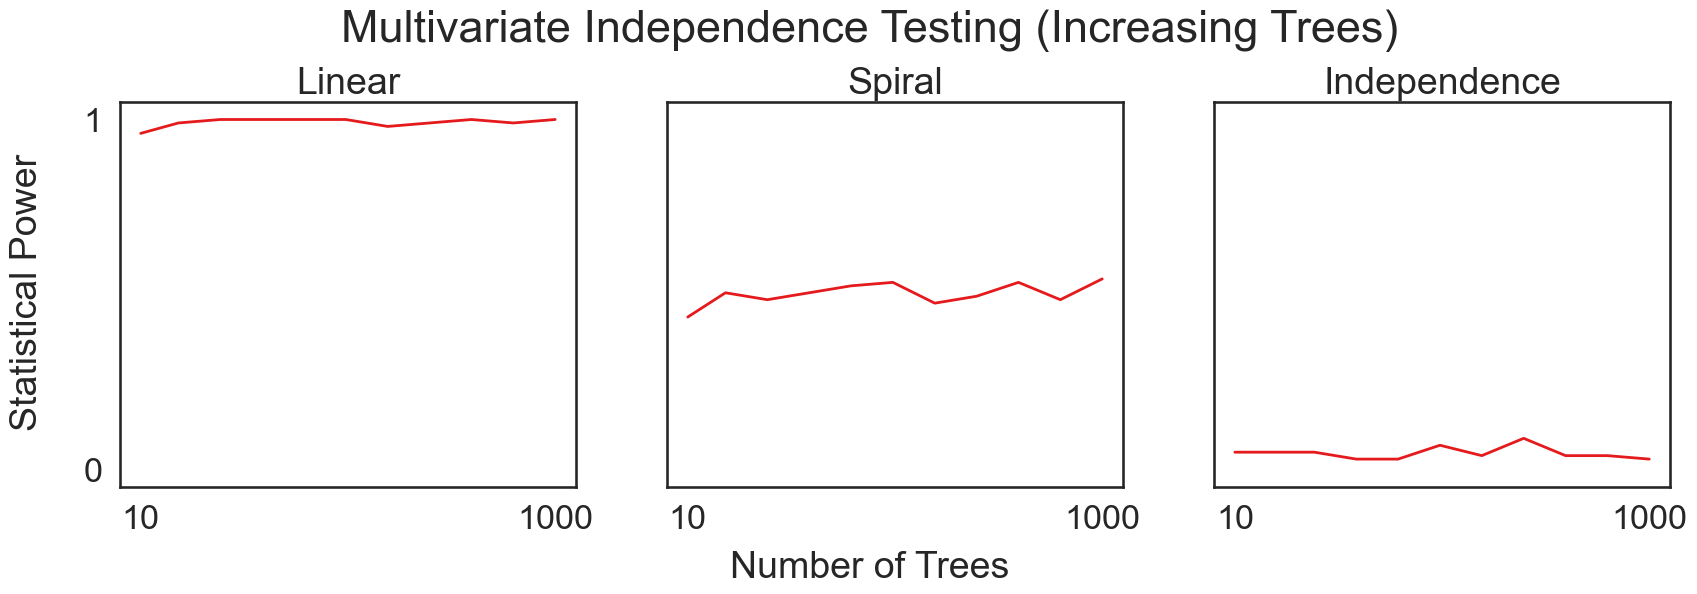

In [7]:
plot_power()